In [14]:
import os
from dotenv import load_dotenv
import gym
import torch
import torch.nn as nn
import random
from collections import namedtuple
import math
import numpy as np
import time
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

In [15]:
env_name = "Taxi-v3"
env = gym.make(env_name)
print('Observation:', env.observation_space.n, env.desc.shape[1], env.desc.shape[0])
print('Action:', env.action_space.n)

Observation: 500 11 7
Action: 6


## Deep QNetwork
nn.module = base for all neural network

In [16]:
class DQN(nn.Module):
    def __init__(self, env):
        super().__init__()
        # init dqn layer
        self.emb = nn.Embedding(500, 10)
        self.fc1 = nn.Linear(in_features=10, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.out_features = nn.Linear(in_features=50, out_features=env.action_space.n)
    
    def forward(self, input_t):
        #print(input_t)
        input_t = nn.functional.relu(self.fc1(self.emb(input_t)))
        #print(input_t)
        #input_t = nn.functional.relu(self.fc1(input_t))
        input_t = nn.functional.relu(self.fc2(input_t))
        input_t = self.out_features(input_t)
        return input_t

## Experience class

In [17]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

## Replay Memory class

In [18]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy class

In [19]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * (current_step) * self.decay) # TODO fix it


## Agent class

In [20]:
class Agent():
    def __init__(self, env, strategy): # TODO add device for torch
        self.current_episode = 0
        self.strategy = strategy
        self.num_actions = env.action_space.n
        self.device = torch.device("cuda:0")
        
    def get_epsilon(self):
        epsilon = self.strategy.get_exploration_rate(self.current_episode)
        return epsilon
    
    def select_action(self, state, policy_network):
        rate = self.strategy.get_exploration_rate(self.current_episode)
        #print(rate)
        # random.uniform(0, 1)?
        if rate > random.random():
            return random.randrange(self.num_actions) # explore
        else:
            with torch.no_grad(): # No grad because we use the model to select an action and not for training
                predicted = policy_network(torch.tensor([state], device=self.device)) # TODO check diff no tensor
                return predicted.argmax(dim=1).item() # exploit    

## Usefull function

In [21]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    tensor_state = torch.cat(batch.state)
    tensor_action = torch.cat(batch.action)
    tensor_reward = torch.cat(batch.reward)
    tensor_next_state = torch.cat(batch.next_state)
    tensor_done = torch.cat(batch.done)
    return (tensor_state, tensor_action, tensor_reward, tensor_next_state, tensor_done)

#https://www.youtube.com/watch?v=ewRw996uevM&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=18 15.00min
class QValues():
    device = torch.device("cuda:0")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(1)) # send all states and actions pairs and get list of qvalues
    
    @staticmethod
    def get_next(target_net, next_states):
        values = target_net(next_states).max(dim=1)[0]
        return values
        
def get_game_state(env):
    device = torch.device("cuda:0")
    taxi_row, taxi_col, pass_idx, dest_idx = env.decode(env.s)
    rend = env.desc.copy()
    if pass_idx < 4:
        rend[1 + env.locs[pass_idx][0]][2 * env.locs[pass_idx][1] + 1] = 'P'
    rend[1 + env.locs[dest_idx][0]][2 * env.locs[dest_idx][1] + 1] = 'D'
    rend[1 + taxi_row][2 * taxi_col + 1] = 'T'
    rend = rend.view(np.uint8).astype(np.float32) # Char to float
    rend = torch.tensor(rend, device=device) # numpy to tensor
    #print(rend.unsqueeze(1))
    return rend.unsqueeze(0)

def moving_average(x, periods=5):
        if len(x) < periods:
            return x
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        res = (cumsum[periods:] - cumsum[:-periods]) / periods
        return np.hstack([x[:periods-1], res])

## Main program

In [22]:
batch_size = 128
gamma = 0.99 # TODO try closer to 0 and graph
eps_start = 1
eps_end = 0.01
eps_delay = 0.001
target_update = 20 # update target network every 20 episode
memory_size = 50000 # TODO try memory size and batch
# TODO add decay function for lr and closer to 1 at first ?
lr = 0.001 # How quickly abandon the previous q value in the table for the new q value for the same pair (s,a) at a later timestep
num_episodes = 3000

In [23]:
device = torch.device("cuda:0")

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_delay)
agent = Agent(env, strategy)
memory = ReplayMemory(memory_size)

policy_net = DQN(env).to(device)
target_net = DQN(env).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # eval mode, not training
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr)


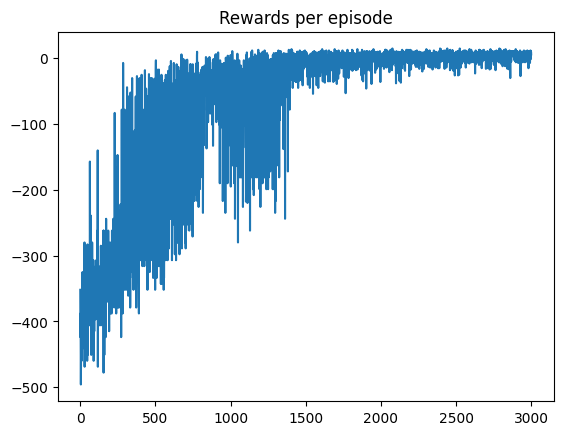

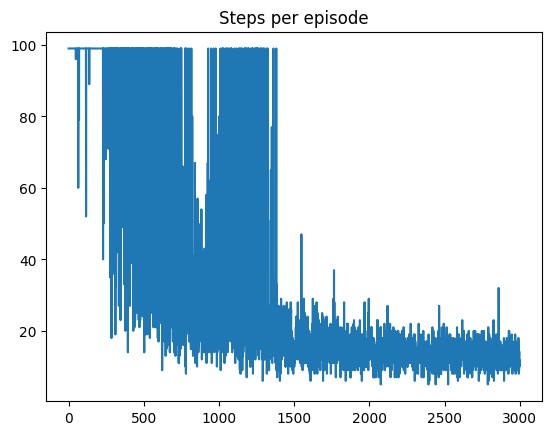

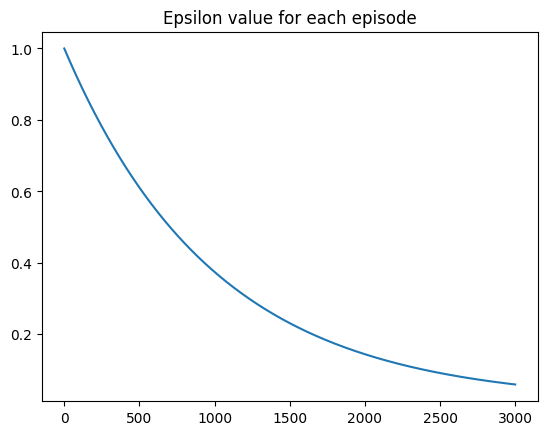

In [24]:
max_step = 100
all_rewards = []
epsilon_vec = []
episode_durations = []
for episode in range(num_episodes):
    #clear_output(wait=True)
    print("Training episode: {0}/{1}".format(episode, num_episodes), end="\r")
    state = env.reset()[0]
    episode_reward = 0
    for step in range(max_step):
        # Do action
        action = agent.select_action(state, policy_net)
        new_state, reward, done, info, _ = env.step(action)
        memory.push(Experience(torch.tensor([state], device=device), 
                               torch.tensor([action], device=device),
                               torch.tensor([new_state], device=device),
                               torch.tensor([reward], device=device),
                               torch.tensor([done], device=device, dtype=torch.bool)))
        state = new_state
        episode_reward += reward
        # Train model
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states_b, actions_b, rewards_b, new_states_b, dones_b = extract_tensors(experiences)
            # predict q values
            current_q_values = QValues.get_current(policy_net, states_b, actions_b)
            # expected q values
            next_q_values = QValues.get_next(target_net, new_states_b)
            #print(next_q_values)
            target_q_values = (next_q_values * gamma) + rewards_b # look better ?
            #target_q_values = (~dones_b * next_q_values * gamma) + rewards_b # TODO check how work ~dones_b
            # compute loss
            loss = nn.functional.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            
            #loss = nn.functional.huber_loss(current_q_values, target_q_values.unsqueeze(1))
            #loss = nn.functional.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))
            # Optimize the model
            optimizer.zero_grad() # prevent accumulating gradients during back props
            loss.backward() # compute the gradient of the loss with respect of weight and biases in the policy net
            for param in policy_net.parameters(): # Clips gradients computed during backpropagation to avoid explosion of gradients
                param.grad.data.clamp_(-1, 1)
            optimizer.step() # update the weight and biases with the just previous gradients computed     
        if done:
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict()) # update target net with policy net weight
    all_rewards.append(episode_reward)
    episode_durations.append(step)
    epsilon_vec.append(agent.get_epsilon())
    agent.current_episode += 1
plt.plot(range(num_episodes), all_rewards)
plt.title("Rewards per episode")
plt.show()
plt.plot(range(num_episodes), episode_durations)
plt.title("Steps per episode")
plt.show()
plt.plot(range(num_episodes), epsilon_vec)
plt.title("Epsilon value for each episode")
plt.show()
    #plot_durations(max_step, episode_durations, all_rewards, epsilon_vec)

In [26]:
# Evaluate agent's performance after Q-learning
DOWN = 0
UP = 1
RIGHT = 2
LEFT = 3
PICKUP = 4
DROP = 5

epochs = 0

total_epochs, total_penalties = 0, 0
episodes = 20

for _ in range(episodes):
    env = gym.make("Taxi-v3", render_mode="human").env
    state = env.reset()[0]

    epochs, penalties, reward, episode_reward = 0, 0, 0, 0
    episode_action = [0, 0, 0, 0, 0, 0]

    done = False

    while not done:
        action = agent.select_action(state, policy_net)
        episode_action[action] += 1
        state, reward, done, info, _ = env.step(action)
        episode_reward += reward

        if reward == -10:
            penalties += 1

        epochs += 1
        env.render()
    env.close()
    
    # wandb.log({"reward": episode_reward, "duration": epochs,
    #            "penalties": penalties,
    #            "down": episode_action[DOWN],
    #            "up": episode_action[UP],
    #            "right": episode_action[RIGHT],
    #            "left": episode_action[LEFT],
    #            "Pickup": episode_action[PICKUP],
    #            "Drop": episode_action[DROP]})

    total_penalties += penalties
    total_epochs += epochs
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")



Results after 20 episodes:
Average timesteps per episode: 12.95
Average penalties per episode: 0.3
